<a href="https://colab.research.google.com/github/MAHA06/ThesisOulu/blob/master/Adversarials/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
# from google.colab import drive
# drive.mount(‘/content/gdrive’)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
np.random.seed(42) 
torch.manual_seed(42)
import pickle
import matplotlib.pyplot as plt


In [11]:
train_batch,test_batch=128,128
img_size=(28,28)
num_classes=10
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True) 
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

In [12]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.softmax(x, dim=1)
    return output




In [13]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using the device:",device)

Using the device: cpu


In [14]:
def fitModel(model,optimizer,scheduler,criterion,device,train_loader,val_loader,epochs):
  data_loader={'train':train_loader,'val':val_loader}
  print("Starting to fit the model")
  train_error,test_error=[],[]
  best_points=np.zeros(img_size+(num_classes,),dtype=float)
  best_scores=np.full(num_classes,-np.inf)
  print(best_scores[1])
  for epc in range(epochs):
    loss_epoch,val_loss_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        
        input,label=data[0].to(device),data[1].to(device)
        # print(input.shape)
        out=model(input)
        # print(out)
        loss=criterion(out,label)
        predict_label=torch.argmax(out,dim=1)
        out=out.squeeze().detach().cpu().numpy()
        if phase == 'train':
          optimizer.zero_grad()

          loss.backward()
          optimizer.step()
          loss_epoch+=loss.item()
          # print(predict_label.item(),label.item())
          # print(out[predict_label.item()],best_scores[predict_label.item()])
          # print(out)
          if epc == epochs-1 and predict_label.item()==label.item() and out[predict_label.item()]>best_scores[predict_label.item()]:#if last epoch and the predicted label is correct
            best_scores[predict_label.item()]=out[predict_label.item()]
            best_points[:,:,predict_label]=input.squeeze().detach().cpu().numpy()
            # print(label.item(),out[label.item()])
            # print("The scores were updated:",best_scores)
        else:
          val_loss_epoch+=loss.item()
    scheduler.step(val_loss_epoch/len(val_loader))
    print("Epoch : {} Train Loss : {} Eval Loss : {}".format(epc+1,loss_epoch/len(train_loader),val_loss_epoch/len(val_loader)))
    train_error.append(loss_epoch)
    test_error.append(val_loss_epoch)
  
  return train_error,test_error,best_points,best_scores
        
          




In [15]:
model=Net().to(device)

optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


###############


In [186]:
## RUN THE TRAINING
loss,val_loss,best_points,best_scores=fitModel(model,optimizer,scheduler,criterion,device,train_loader,val_loader,1)


Starting to fit the model
-inf
Epoch : 1 Train Loss : -0.842552869892936 Eval Loss : -0.9287422099167317


(28, 28, 10)
tensor([[1.4239e-28, 1.1498e-22, 6.9919e-14, 1.0000e+00, 5.8801e-18, 5.2523e-21,
         6.5902e-38, 1.8411e-14, 4.6206e-17, 7.8552e-15]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor(3, device='cuda:0')
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


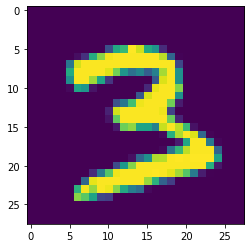

In [190]:
print(best_points.shape)
plt.imshow(best_points[:,:,3])
v=torch.tensor(best_points[:,:,3].reshape(1,1,28,28),dtype=torch.float32)
print(model(v.to(device)))
print(torch.argmax(model(v.to(device))))
print(best_scores)

In [193]:
filename = './Models/model_MNIST'
pickle.dump(model, open(filename, 'wb'))
filename = './Models/model_MNIST_cpu'
pickle.dump(model.cpu(), open(filename, 'wb'))

In [16]:
def deepfool(image, net, num_classes, overshoot, max_iter):

    """
       :param image:
       :param net: network (input: images, output: values of activation **BEFORE** softmax).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """

    is_cuda = torch.cuda.is_available()
    if is_cuda:
        image = image.cuda()
        net = net.cuda()

    f_image = net.forward(Variable(image[None, :, :, :], requires_grad=True)).data.cpu().numpy().flatten()
    I = f_image.argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = Variable(pert_image[None, :], requires_grad=True)
    fs = net.forward(x)
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            zero_gradients(x)

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        if is_cuda:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).cuda()
        else:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = Variable(pert_image, requires_grad=True)
       # print(image.shape)
       # print(x.view(1,1,image.shape[0],-1).shape)
        fs = net.forward(x.view(1,1,image.shape[1],-1))
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    return (1+overshoot)*r_tot, loop_i, label, k_i, pert_image
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [17]:
def JacobianMatrix(model,input):
  print("Input size ",input.shape)
  number_of_piels=input.shape[0]*input.shape[1]
  J = torch.zeros ((1, 784, 10))   # loop will fill in Jacobian
  input.requires_grad = True
  preds = model (input)
  for  i in range (10):
      grd = torch.zeros ((1, 10))   # same shape as preds
      grd[0, i] = 1    # column of Jacobian to compute
      preds.backward (gradient = grd, retain_graph = True)
      J[:,:,i] = input.grad   # fill in one column of Jacobian
      input.grad.zero_()   # .backward() accumulates gradients, so reset to zero
def JSM_attack(model, input):
  input.requires_grad=True

In [91]:
activation_in = {}
activation_out={}
def get_activation_input(name):
    def hook(model, input, output):
        activation_in[name] = input[0].data
    return hook
def get_activation_output(name):
    def hook(model, input, output):
        activation_out[name] = output.clone().detach()
    return hook
def nth_derivative(f, wrt, n):

    for i in range(n):

        grads = torch.autograd.grad(f, wrt, create_graph=True)[0]
        f = grads.sum()

    return grads
def get_higher_gradients(model,input,label, rank=3):
  grads=[1,2,3]
  optimizer.zero_grad()
  input.requires_grad=True
  outs=model(input)
  pred=torch.zeros(num_classes)
  pred[label.item()]=1
  l=criterion(outs,label)
  aux=torch.autograd.grad(l,input,retain_graph=True,create_graph=True)[0]
  grads.append(aux.reshape(1,-1))
  for r in range(2,rank+1):
    aux=torch.autograd.grad(aux.sum(),input,create_graph=True)[0]
    grads.append(aux.reshape(1,-1))
  return grads
def check_taylor_prediction(model,input,marker_images,perturbed_label):
  plt.imshow(input.squeeze().detach().cpu().numpy())
  # grads=get_higher_gradients(model,input,true_label)

  # grads=get_higher_gradients(model,input,perturbed_label)
  layer_grads=get_layer_gradients(model,input,perturbed_label,"conv2")
  input=input.reshape(-1,1)
  # marker_image=marker_images[:,:,true_label.item()].reshape(-1,1)
  # marker_image=torch.tensor(marker_image,dtype=torch.float32)
  # total=1.+torch.mm(grads[0],(input-marker_image))+torch.mm(grads[1],torch.pow((input-marker_image),2))/2
  # total=1.+torch.mm(grads[0],(input-marker_image))+torch.mm(grads[1],torch.pow((input-marker_image),2))/2
  marker_image1=marker_images[:,:,perturbed_label.item()].reshape(-1,1)
  marker_image1=torch.tensor(marker_image1,dtype=torch.float32)
  total1=torch.mm(layer_grads[0],(input-marker_image1))+torch.mm(layer_grads[1],torch.pow((input-marker_image1),2))/2

  return total1.item()
def get_layer_gradients(model,input,label,l_name, rank=3):
  grads=[]
  optimizer.zero_grad()
  input.requires_grad=True
  outs=model(input)
  pred=torch.zeros(num_classes)
  pred[label.item()]=1
  l=criterion(outs,label)
  # layer_input_data=activation_in[l_name]
  # layer_input_data.requires_grad=True
  layer_input_data=0
  # aux=torch.autograd.grad(l,layer_input_data,retain_graph=True,create_graph=True)[0]
  # grads.append(aux.reshape(1,-1))
  # for r in range(2,rank+1):
  #   aux=torch.autograd.grad(aux.sum(),layer_input_data,create_graph=True)[0]
  #   grads.append(aux.reshape(1,-1))
  return grads


In [98]:
filename = './model_MNIST_cpu.mf'
model= pickle.load(open(filename, 'rb'))
filename = './scores.mf'

best_fits=pickle.load(open(filename,'rb'))

IndexError: list index out of range

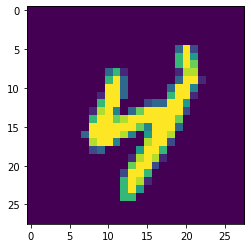

In [101]:


def testModel(model,criterion,device,test_loader,attack):
  count=0
  totals=0
  fooled=0
  for data,labels in test_loader:
    data,labels=data.to(device),labels.to(device)
    data.requires_grad=True
    outs=model(data)
    true_preds=torch.argmax(outs,dim=1)
    if true_preds!=labels:
      continue
    epsilon=0.1
    true_loss=criterion(outs,labels)
    true_loss.backward()
    data_grad=data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    elif attack == "jacobian":
      print("Implement the jacobian")
    p_out=model(perturbed_data)
    perturb_label=torch.argmax(p_out,dim=1)
    # print(perturb_label.item())

    if perturb_label!=labels:
      totals+=1
      # print("Trying to determine for the true class:",labels.item()," which was labeled as:",perturb_label.item())
      x=range(0,num_classes)
      x=[check_taylor_prediction(model,data,best_fits['b_p'],torch.tensor(lab).reshape(1)) for lab in x ]
      winner=np.argmax(x)
      if winner == true_preds.item():
        fooled+=1
      if winner == labels.item():
        count+=1
      # r=check_taylor_prediction(model,data,best_fits['b_p'],perturb_label)
      print("Total of :",count/totals)
      print("Fooled :",fooled/totals)
# conv2
model.conv2.register_forward_hook(get_activation_input('conv2'))

# model.conv2.register_forward_hook(get_activation_output('conv2'))
testModel(model,criterion,'cpu',test_loader,"ifgsm")



